# Inverse PCA

Let's explore the "latent space" of `PCA`.

We can think of `PCA` as a kind of factorization or decomposition of our original images into $2$ values each: one that is a new reduced set of features, called the principal components, and the other is a set of common features extracted from all images.

So, each image $I_i$ can now be represented as a multiplication $I_i = PC_i \cdot V$, where $PC_i$ are the principal components of $I_i$, and $V$ are the common values extract from all images.

Let's look at an example.

## Setup

First we download some libraries and data, and import helpers.

In [1]:
!wget -q https://github.com/PSAM-5020-2025S-A/5020-utils/raw/main/src/data_utils.py
!wget -q https://github.com/PSAM-5020-2025S-A/5020-utils/raw/main/src/image_utils.py

!wget -qO- https://github.com/PSAM-5020-2025S-A/5020-utils/releases/latest/download/att-faces.tar.gz | tar xz
!wget -qO- https://github.com/PSAM-5020-2025S-A/5020-utils/releases/latest/download/metfaces.tar.gz | tar xz

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import PIL.Image as PImage

from numpy.random import normal as np_normal, randint
from os import listdir, path

from data_utils import PCA, StandardScaler
from image_utils import get_pixels, make_image

## Load Dataset

This is the `AT&T` faces dataset with $400$ images that have been cropped and somewhat aligned.

In [3]:
# img_width = 92

# lists for keeping track of image pixel lists, subject numeric id and subject label
face_pixels = []

# 40 directories
for l in range(1, 41):
  # 10 images per directory
  for i in range(1, 11):
    mimg = PImage.open(f"./data/image/att-faces/s{l}/{i}.pgm")
    img_width = mimg.size[0]
    face_pixels.append(get_pixels(mimg))

## Start Processing

Get some info about our data, and run `PCA` on all images/rows.

400  X  10304


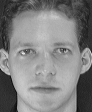

In [4]:
# Dataset shape
print(len(face_pixels), " X ", len(face_pixels[0]))

# display first image
display(make_image(face_pixels[0], width=img_width))

### PCA and Resulting Transformation

We can see how much information from the original data was kept by our `PCA` transformation, and what common components were extracted.

In [5]:
# run pca and get first 256 PCs
pca = PCA(n_components=256)
faces_df = pca.fit_transform(face_pixels)

print("explained variance:", pca.explained_variance())

# shape of the common values V
print("common values V", pca.components.shape)

# shape of resulting dataframe
print("Resulting DataFrame:", faces_df.shape[0], "rows and", faces_df.shape[1], "features (principal components)")

explained variance: 0.9734781085189637
common values V (256, 10304)
Resulting DataFrame: 400 rows and 256 features (principal components)


The common extracted values are themselves $256$ images.

### Reconstruct

We now have each of our images represented with $256$ values. They've been compressed from $10\text{,}304$ pixels to $256$ components. Since we're only using a portion of the total number of components, we won't be able to fully recuperate the original images, but we should be able to get something pretty close since we're keeping more than $90\%$ of the information from the original images.

Instead of breaking our images down into principal components and common factors, we also have an error $e_i$:

$I_i = PC_i \cdot V + e_i$

But, we can still use $PC_i \cdot V$ to reconstruct our original images.

We can transform the $256$ values back into $10\text{,}304$ pixels using the `inverse_transform()` function of our `PCA` object.

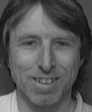

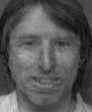

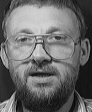

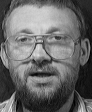

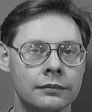

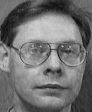

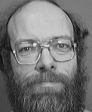

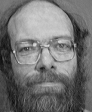

In [6]:
# Reconstruction: transforms the data from PCA space into pixel space
pca_pixels = pca.inverse_transform(faces_df)

for i in range(4):
  idx = randint(0, len(face_pixels))
  display(make_image(face_pixels[idx], width=img_width))
  display(make_image(pca_pixels.loc[idx], width=img_width))

### Common Factors

These are the common values extracted from the dataset. It's the value $V$ from the equation:

$I_i = PC_i \cdot V + e_i$

All reconstructions are built from linear combinations of these features that are common between all images.

There are $256$ of them, one for each $PC$ component extracted, but let's only look at the first $4$, since those are the most important/common shapes present in our images.

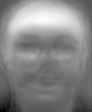

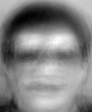

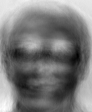

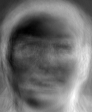

In [7]:
for comp in pca.components[:4]:
  minVal = comp.min()
  maxVal = comp.max()
  # manually mapping to [0, 255]
  pxs01 = 255 * (comp - minVal) / (maxVal - minVal)
  display(make_image(pxs01, width=img_width))

### Standardize the PC values

We have a new dataset that is made up of $256$ PC features.

The range of values for the $PC$ feature are very different. The first few components of each image tend to have values that are a lot larger than the last components. This is expected and part of the process of making more common features be turned into more important components. The components are ordered by the amount of variance they explain.

If we were to use the PC features to train a classifier, we would keep them unscaled, but we can scale them as part of our current exploratory analysis.

This helps understand the distribution of their values and will also help us pick sensible random values for them later.

In [8]:
# Look at distributions of un-normalized PC values
faces_df.describe().round(3)

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC246,PC247,PC248,PC249,PC250,PC251,PC252,PC253,PC254,PC255
count,400.000,400.000,400.000,400.000,400.000,400.000,400.000,400.000,400.000,400.000,...,400.000,400.000,400.000,400.000,400.000,400.000,400.000,400.000,400.000,400.000
mean,-0.000,-0.000,0.000,0.000,-0.000,0.000,-0.000,-0.000,0.000,0.000,...,-0.000,-0.000,-0.000,0.000,0.000,-0.000,-0.000,-0.000,0.000,-0.000
std,1680.449,1438.659,1047.400,945.861,905.228,734.319,626.449,611.404,560.949,537.679,...,68.150,68.038,67.475,67.409,67.274,66.561,66.391,66.050,65.458,65.341
min,-3305.631,-3699.879,-2106.404,-2720.054,-2518.656,-1956.908,-1739.368,-1600.372,-1546.421,-1478.873,...,-201.641,-217.597,-187.501,-202.653,-221.820,-188.441,-179.746,-202.183,-169.354,-189.390
25%,-1442.059,-847.847,-1001.369,-565.740,-625.850,-486.307,-426.720,-410.654,-364.256,-330.790,...,-45.617,-48.870,-43.972,-40.329,-49.034,-40.573,-40.674,-45.760,-43.863,-40.377
50%,105.519,213.436,158.003,2.606,6.099,-34.683,-37.831,11.020,-62.057,-26.646,...,1.436,2.374,-0.966,-1.077,2.901,-8.499,-3.739,-1.821,3.085,-3.644
75%,1314.584,1055.313,865.111,608.705,662.003,472.928,442.506,464.781,396.047,296.186,...,43.302,51.116,44.653,36.776,39.367,45.191,44.152,46.095,45.370,45.455
max,3771.269,3604.879,2128.365,2717.876,2506.667,1785.723,1649.720,1526.763,1286.603,1645.376,...,223.074,230.358,222.144,232.363,230.068,314.184,228.035,180.044,288.183,172.991


In [9]:
# scale the PCs
pca_scaler = StandardScaler()
faces_pca_std_df = pca_scaler.fit_transform(faces_df)

display(faces_pca_std_df)
display(faces_pca_std_df.describe().round(3))

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC246,PC247,PC248,PC249,PC250,PC251,PC252,PC253,PC254,PC255
0,0.912312,0.746198,-1.784767,0.277115,0.763104,-0.168791,0.678037,-0.618282,-0.784350,-1.922070,...,-0.955564,0.896303,-1.176855,0.119428,0.167866,0.227710,-1.490301,-0.000584,-1.737596,0.809531
1,1.773111,0.528850,0.441465,1.276967,2.772568,0.523908,1.965907,0.531382,-0.688885,0.136075,...,-0.120768,0.496559,-1.266311,0.805070,0.436703,1.065128,3.439029,-1.162159,0.224617,-0.896258
2,1.606610,0.264825,-0.960684,-0.033565,1.138821,-1.474162,0.740446,0.389073,-1.992926,-1.530684,...,0.368162,-0.864933,-1.616800,1.390651,0.267279,-0.069003,-0.142306,0.741888,-0.115026,-0.895767
3,1.931894,0.809326,0.215185,2.877040,-0.023266,-1.119343,-1.083995,-1.577709,0.867513,-1.651339,...,-1.529575,0.932602,0.949726,-0.719261,0.347520,1.310188,0.855322,-0.630743,-0.137124,0.617466
4,2.171550,0.562926,-0.111178,2.251124,0.237753,-0.629657,0.856389,0.338031,0.190149,-0.212601,...,-0.629804,-0.143308,0.351838,-0.719865,-1.347844,-0.034612,-0.156113,-1.082478,0.458072,1.163082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0.390067,0.717647,1.504927,-0.505813,0.004137,-0.652286,0.089961,1.885536,-1.614974,-0.878112,...,0.455939,0.252955,-0.135322,-1.610378,1.358816,-0.104261,1.717076,-0.782299,0.394702,0.680456
396,0.678599,0.878619,1.013036,-0.654416,0.409135,-0.581648,-0.615042,-1.538230,0.304544,-0.088453,...,-0.965249,0.531062,1.632408,-0.271851,-1.235410,-1.333769,0.262054,0.915965,0.300334,-1.495540
397,0.502368,0.660979,1.473241,-0.251508,-0.612483,-0.260708,0.173099,1.299154,-1.910181,-0.516076,...,0.858943,1.941971,-0.138453,-1.053573,0.213375,-1.510125,-0.289904,0.469229,0.812881,-0.099304
398,0.834522,0.888334,0.771359,0.121930,0.324351,-1.095225,-1.677227,-2.158193,0.837536,0.080872,...,1.588938,0.232537,0.206235,0.453109,0.251063,0.823143,0.200568,1.024175,0.060455,-0.616352


,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC246,PC247,PC248,PC249,PC250,PC251,PC252,PC253,PC254,PC255
count,400.000,400.000,400.000,400.000,400.000,400.000,400.000,400.000,400.000,400.000,...,400.000,400.000,400.000,400.000,400.000,400.000,400.000,400.000,400.000,400.000
mean,-0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,-0.000,...,-0.000,-0.000,-0.000,0.000,-0.000,0.000,0.000,-0.000,-0.000,-0.000
std,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001,...,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001
min,-1.970,-2.575,-2.014,-2.879,-2.786,-2.668,-2.780,-2.621,-2.760,-2.754,...,-2.962,-3.202,-2.782,-3.010,-3.301,-2.835,-2.711,-3.065,-2.590,-2.902
25%,-0.859,-0.590,-0.957,-0.599,-0.692,-0.663,-0.682,-0.672,-0.650,-0.616,...,-0.670,-0.719,-0.652,-0.599,-0.730,-0.610,-0.613,-0.694,-0.671,-0.619
50%,0.063,0.149,0.151,0.003,0.007,-0.047,-0.060,0.018,-0.111,-0.050,...,0.021,0.035,-0.014,-0.016,0.043,-0.128,-0.056,-0.028,0.047,-0.056
75%,0.783,0.734,0.827,0.644,0.732,0.645,0.707,0.761,0.707,0.552,...,0.636,0.752,0.663,0.546,0.586,0.680,0.666,0.699,0.694,0.697
max,2.247,2.509,2.035,2.877,2.773,2.435,2.637,2.500,2.296,3.064,...,3.277,3.390,3.296,3.451,3.424,4.726,3.439,2.729,4.408,2.651


### Plot distribution of PCs

This is exploratory.

For each image, we'll plot its first $32$ features.

In the same plot, highlight the values for the first $4$ images in our dataset.

All the red dots are the PC values that are needed to reconstruct the first image, shown in relation to the distribution of all the values of the PCs of all images.

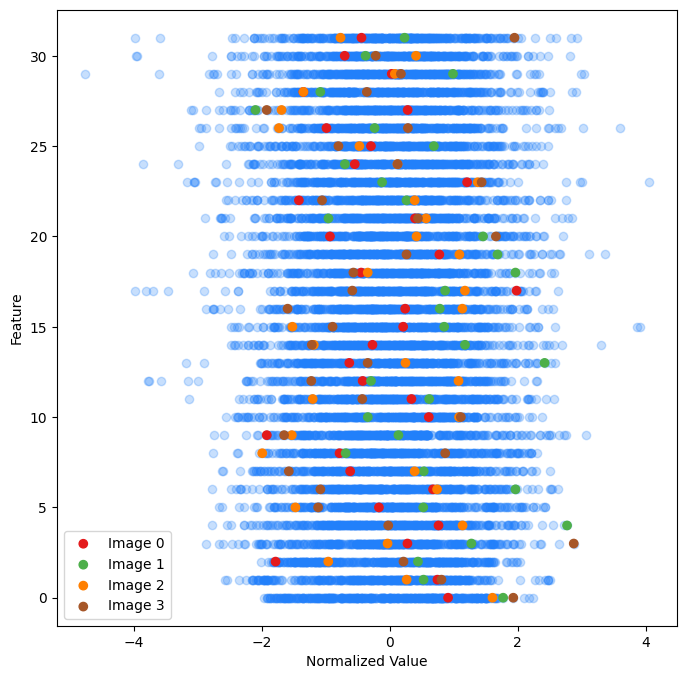

In [10]:
num_pcs = 32
num_faces = 4
cmap = plt.get_cmap("Set1")

plt.figure(figsize=(8,8))
for i in range(0,num_pcs):
  plt.scatter(faces_pca_std_df[f"PC{i}"], faces_pca_std_df.shape[0] * [i], alpha=0.25, color='#2280fa')


for i in range(num_faces):
  pcs = faces_pca_std_df.iloc[i].values[:num_pcs]
  mcolor = cmap(i/num_faces)
  plt.scatter(pcs, range(num_pcs), c=num_pcs*[mcolor], label=f"Image {i}")

plt.xlabel("Normalized Value")
plt.ylabel("Feature")
plt.legend(loc="lower left")
plt.show()

### Most Average Face

Our simplified math representation of the `PCA` transformation shows that we can get face images $I_i$ by multiplying $256$ PC values by $256$ images (the $V$ components):

$PC_i \cdot V \rightarrow I_i$

So far, the PC values we've been using to reconstruct images were coming from the original dataset, but the $V$ values should have enough information about faces that if we multiply any set of $256$ values by $V$ it should give us a face.

Let's start by looking at what happens if we construct an image from the average value of all of the PCs.

This could be the `DataFrame` we get by computing `mean()` for all PCs in their original ranges: `faces_df.mean()`, but since those features were themselves normalized, they would all have an average value of $0$.

This means we can re-construct the most average face of our dataset by `inverse_transforming()` a list of $256$ zeroes.

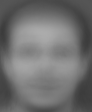

In [11]:
avg_std_df = pd.DataFrame([pca.n_components * [0]], columns=faces_df.columns)
avg_pca_df = pca_scaler.inverse_transform(avg_std_df)

avg_img = pca.inverse_transform(avg_pca_df)
display(make_image(avg_img.loc[0], width=img_width))

### Random Faces

We can also reconstruct faces from $256$ random values.

We could pick them completely random, but let's use normal distributions to make sure we don't go too far from the average value of any particular component.

We'll create a `DataFrame` that has $4$ faces represented in scaled `PCA` space.

We'll then un-scale and un-PCA these values to create $4$ random faces that are very unlikely to be in our original dataset, but that are re-created based on real data features that were extracted in the form of principal components.

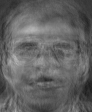

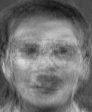

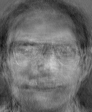

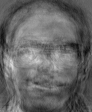

In [12]:
num_ifaces = 4

rand_std_pcs = pd.DataFrame(np_normal(size=[num_ifaces, pca.n_components], scale=0.666), columns=faces_df.columns)
rand_pcs = pca_scaler.inverse_transform(rand_std_pcs)
rand_img = pca.inverse_transform(rand_pcs)

for i in range(num_ifaces):
  display(make_image(rand_img.loc[i], width=img_width))

## Bonus Dataset

The re-constructed random faces look like faces, but the `AT&T` images are not very diverse ($40$ people), and, since part of the original experiment with these faces was to see how robust this method was to minor variations in face positioning, the faces aren't very well aligned.

We can see that very clearly in the reconstructions. It's like there are a bunch ($256$ to be exact) faces being superimposed, but they're not aligned.

Here's a dataset that has $1336$ unique faces that have been better aligned and scaled.

Run this cell and then repeat the process starting from the _Start Processing_ cell above.

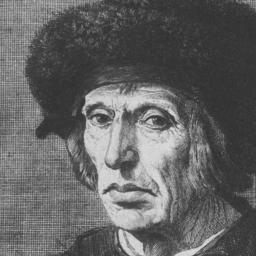

In [13]:
img_width = 256
MET_PATH = f"./data/image/metfaces/{img_width}"

face_pixels = []

for f in sorted([f for f in listdir(MET_PATH) if f.endswith(".jpg")]):
  mimg = PImage.open(path.join(MET_PATH, f)).convert("L")
  face_pixels.append(list(mimg.getdata()))

display(mimg)

1336  X  65536


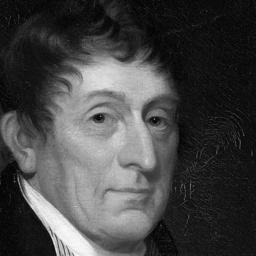

In [14]:
# Dataset shape
print(len(face_pixels), " X ", len(face_pixels[0]))

# display first image
display(make_image(face_pixels[0], width=img_width))

In [15]:
# run pca and get first 256 PCs
pca = PCA(n_components=256)
faces_df = pca.fit_transform(face_pixels)

print("explained variance:", pca.explained_variance())

# shape of the common values V
print("common values V", pca.components.shape)

# shape of resulting dataframe
print("Resulting DataFrame:", faces_df.shape[0], "rows and", faces_df.shape[1], "features (principal components)")

explained variance: 0.9611794953787625
common values V (256, 65536)
Resulting DataFrame: 1336 rows and 256 features (principal components)


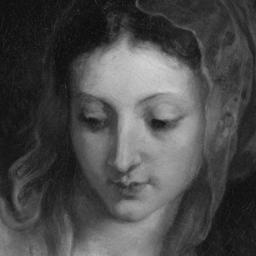

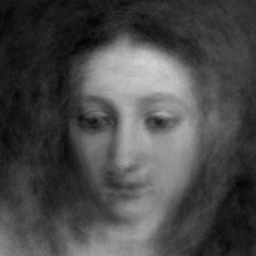

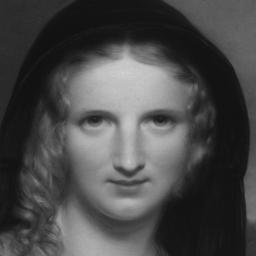

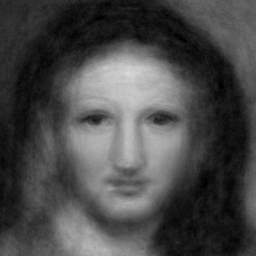

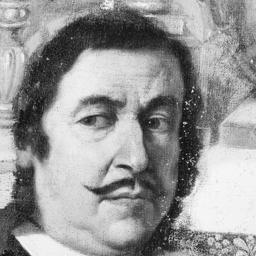

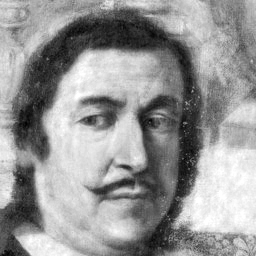

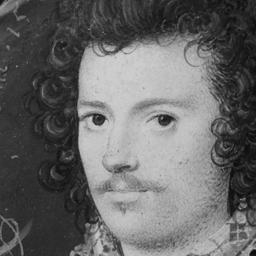

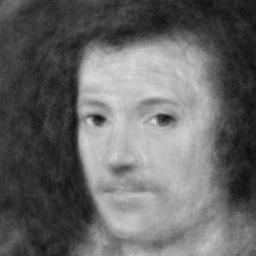

In [16]:
# Reconstruction: transforms the data from PCA space into pixel space
pca_pixels = pca.inverse_transform(faces_df)

for i in range(4):
  idx = randint(0, len(face_pixels))
  display(make_image(face_pixels[idx], width=img_width))
  display(make_image(pca_pixels.loc[idx], width=img_width))

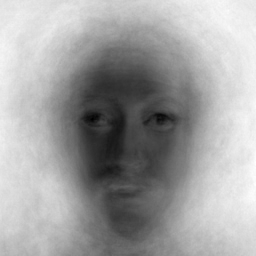

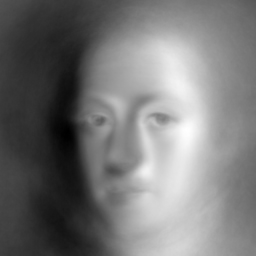

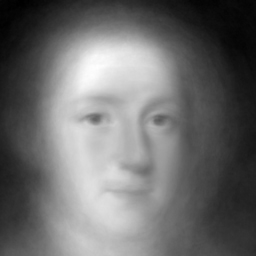

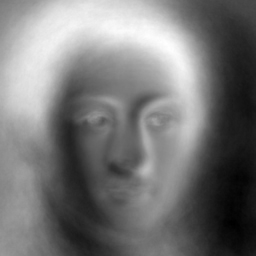

In [17]:
for comp in pca.components[:4]:
  minVal = comp.min()
  maxVal = comp.max()
  # manually mapping to [0, 255]
  pxs01 = 255 * (comp - minVal) / (maxVal - minVal)
  display(make_image(pxs01, width=img_width))

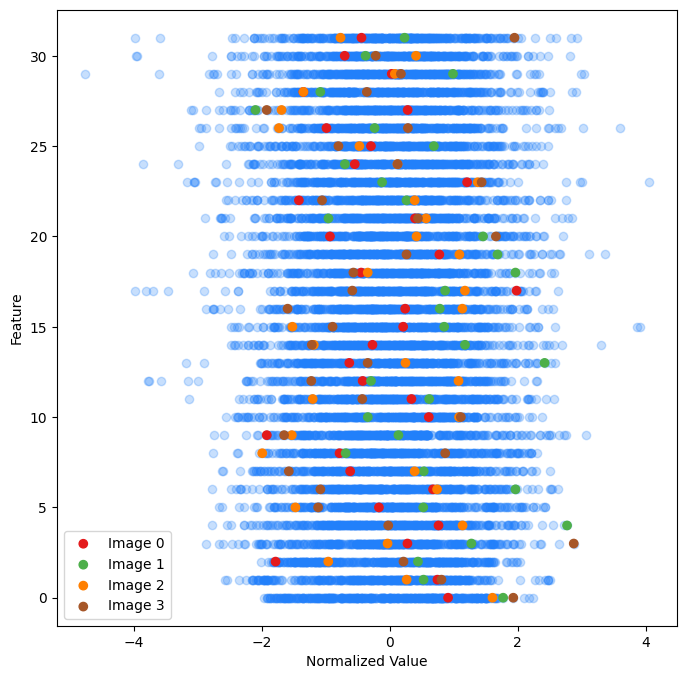

In [18]:
num_pcs = 32
num_faces = 4
cmap = plt.get_cmap("Set1")

plt.figure(figsize=(8,8))
for i in range(0,num_pcs):
  plt.scatter(faces_pca_std_df[f"PC{i}"], faces_pca_std_df.shape[0] * [i], alpha=0.25, color='#2280fa')


for i in range(num_faces):
  pcs = faces_pca_std_df.iloc[i].values[:num_pcs]
  mcolor = cmap(i/num_faces)
  plt.scatter(pcs, range(num_pcs), c=num_pcs*[mcolor], label=f"Image {i}")

plt.xlabel("Normalized Value")
plt.ylabel("Feature")
plt.legend(loc="lower left")
plt.show()

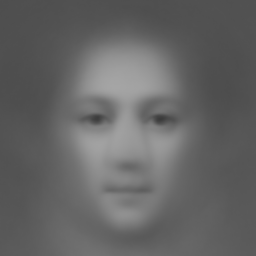

In [19]:
avg_std_df = pd.DataFrame([pca.n_components * [0]], columns=faces_df.columns)
avg_pca_df = pca_scaler.inverse_transform(avg_std_df)

avg_img = pca.inverse_transform(avg_pca_df)
display(make_image(avg_img.loc[0], width=img_width))

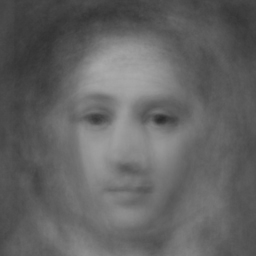

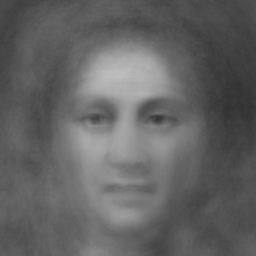

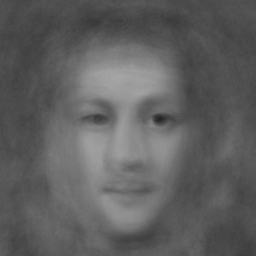

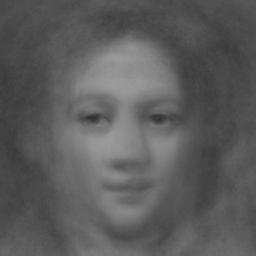

In [20]:
num_ifaces = 4

rand_std_pcs = pd.DataFrame(np_normal(size=[num_ifaces, pca.n_components], scale=0.666), columns=faces_df.columns)
rand_pcs = pca_scaler.inverse_transform(rand_std_pcs)
rand_img = pca.inverse_transform(rand_pcs)

for i in range(num_ifaces):
  display(make_image(rand_img.loc[i], width=img_width))